<a href="https://colab.research.google.com/github/saguileran/MD-SCPI/blob/main/NoteBooks/pyPARSER_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install Conda Colab**

This cell must be always be run

In [1]:
#It will restart the kernel (session), don't worry.
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


install dependecies

In [2]:
%%capture
import sys
!pip -q install py3Dmol
!pip install git+https://github.com/pablo-arantes/biopandas
!mamba install openmmforcefields -c conda-forge -y
!git clone https://github.com/pablo-arantes/ProLIF.git
prolif1 = "cd /content/ProLIF"
prolif2 = "sed -i 's/mdanalysis.*/mdanalysis==2.0.0/' setup.cfg"
prolif3 = "pip install ."

original_stdout = sys.stdout # Save a reference to the original standard output

with open('prolif.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(prolif1)
    print(prolif2)
    print(prolif3)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 prolif.sh 2>&1 1>/dev/null
!bash prolif.sh >/dev/null 2>&1
!mamba install -c conda-forge openbabel -y
!mamba install -c conda-forge ambertools -y
!mamba install -c conda-forge parmed -y
!mamba install -c conda-forge ipympl
!mamba install -c conda-forge nglview
!mamba install -c anaconda pyparsing
!pip install --upgrade MDAnalysis

#load dependencies
from openmm import app, unit
from openmm.app import HBonds, NoCutoff, PDBFile
from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField
from openff.toolkit.utils import get_data_file_path
import parmed as pmd
from biopandas.pdb import PandasPdb
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import os
import urllib.request  
import numpy as np
import MDAnalysis as mda
import py3Dmol
import pytraj as pt
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from pytraj import matrix
from matplotlib import colors
from IPython.display import set_matplotlib_formats
!wget  https://raw.githubusercontent.com/openforcefield/openff-forcefields/master/openforcefields/offxml/openff_unconstrained-2.0.0.offxml

In [4]:
# Import Google Drive
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [118]:
import rdkit
import mdtraj as md
from rdkit import Chem
from rdkit.Chem import AllChem,Draw
from rdkit.Chem.Draw import IPythonConsole
from openbabel import pybel

Protein = 'COL'
workDir = '/content/drive/MyDrive/MolecularDynamics_2023/USP/pyLiBELa/'

Protein_PDB_file_name = 'MR.pdb'
Ligand_PDB_file_name = '{0}/{0}.pdb'.format(Protein)
Ligand_Protein_PDB_file_name = '{0}/MR-{0}_leap.pdb'.format(Protein)
Ligand_Protein_prmtop_file_name = '{0}/MR-{0}.prmtop'.format(Protein)
Ligand_Protein_inpcrd_file_name = '{0}/MR-{0}.inpcrd'.format(Protein)
Ligand_Protein_nc_file_name = '{0}/prod.nc'.format(Protein)


ligand_name = Ligand_PDB_file_name
file_name = os.path.join(workDir, str(Protein_PDB_file_name)) 
nc_name = os.path.join(workDir, str(Ligand_Protein_nc_file_name)) 
param_name = os.path.join(workDir, str(Ligand_Protein_prmtop_file_name)) 


# alignment = align.AlignTraj(trj, ref, filename='rmsfit.dcd') # align trajectory

#ligand_pdb = os.path.join(workDir, str(ligand_name))
#ligand_pdb2 = os.path.join(workDir, "ligand_H.pdb")
#initial_pdb = os.path.join(workDir, "starting0.pdb")
#starting = os.path.join(workDir, "starting1.pdb")
#starting2 = os.path.join(workDir, "starting2.pdb")
#starting_end = os.path.join(workDir, "starting_end.pdb")

pdb_protein = os.path.exists(os.path.join(workDir,Protein_PDB_file_name))
pdb_ligand = os.path.exists(os.path.join(workDir,Ligand_PDB_file_name))
prmtop_system = os.path.exists(os.path.join(workDir,Ligand_Protein_prmtop_file_name))
nc_system = os.path.exists(os.path.join(workDir,Ligand_Protein_nc_file_name))
inpcrd_system = os.path.exists(os.path.join(workDir,Ligand_Protein_inpcrd_file_name))


if pdb_protein == True and pdb_ligand == True and prmtop_system == True and nc_system == True and inpcrd_system == True:
    print("Files loaded succesfully! =)")
else:
    print("ERROR! Check your input names and Google Drive path")

Files loaded succesfully! =)


#  **Import pytraj package and trajectory file**

[pytraj.all_actions documentation](https://amber-md.github.io/pytraj/latest/_api/pytraj.all_actions.html)

In [164]:
import pytraj as pt

traj = pt.iterload(nc_name, param_name)

mask = ":{}".format("MOL") #"@CA"
mask_label = "_{}".format(Protein) #"@CA"
number_frames_analysis = len(traj)

traj_align = pt.align(traj, mask='', ref=0, ref_mask='', mass=False, top=None, frame_indices=None)

print(traj)

%matplotlib ipympl 
#enable interactive plots

pytraj.TrajectoryIterator, 301 frames: 
Size: 0.331059 (GB)
<Topology: 49207 atoms, 15294 residues, 15038 mols, PBC with box type = orthorhombic>
           


In [172]:
traj.metadata

<ipython-input-172-986887a135d1>:1: DeprecationWarning: deprecated, use crdinfo
  traj.metadata


{'has_velocity': False,
 'has_temperature': False,
 'has_time': True,
 'has_force': False,
 'has_box': True,
 'has_replcica_dims': False,
 'n_frames': 301,
 'n_atoms': 49207,
 'box_type': 'orthorhombic'}

In [177]:
output.enable_custom_widget_manager()
traj.visualize()

NGLWidget(max_frame=300)

In [178]:
#help(traj)

# MD Analysis


Although visualizing your trajectory can be quite useful, sometimes you also want more quantitative data.

Analyses of MD trajectories vary a lot and we do not intend to cover it all here. However, one can make use of MDanalysis or PyTraj to easily analyze simulations. 

Below, you can find a few examples of code snippets that can help you to shed some light on your simulation behavior.

In [126]:
%%time
#@title **Define Secondary Structure of Proteins**
residues, ss, _ = pt.dssp(traj, mask=mask)
dssp_all_atoms = pt.dssp_allatoms(traj, simplified=True)
dssp_all_residues = pt.dssp_allresidues(traj, simplified=True)

print(residues, ss)
print("/n")
print(dssp_all_atoms)
print("/n")
print(dssp_all_residues)

['MOL:1'] ['0' '0' '0' ... '0' '0' '0']
/n
[['C' 'C' 'C' ... 'C' 'C' 'C']
 ['C' 'C' 'C' ... 'C' 'C' 'C']
 ['C' 'C' 'C' ... 'C' 'C' 'C']
 ...
 ['C' 'C' 'C' ... 'C' 'C' 'C']
 ['C' 'C' 'C' ... 'C' 'C' 'C']
 ['C' 'C' 'C' ... 'C' 'C' 'C']]
/n
[['C' 'C' 'C' ... 'C' 'C' 'C']
 ['C' 'C' 'C' ... 'C' 'C' 'C']
 ['C' 'C' 'C' ... 'C' 'C' 'C']
 ...
 ['C' 'C' 'C' ... 'C' 'C' 'C']
 ['C' 'C' 'C' ... 'C' 'C' 'C']
 ['C' 'C' 'C' ... 'C' 'C' 'C']]
CPU times: user 1min 13s, sys: 490 ms, total: 1min 13s
Wall time: 1min 14s


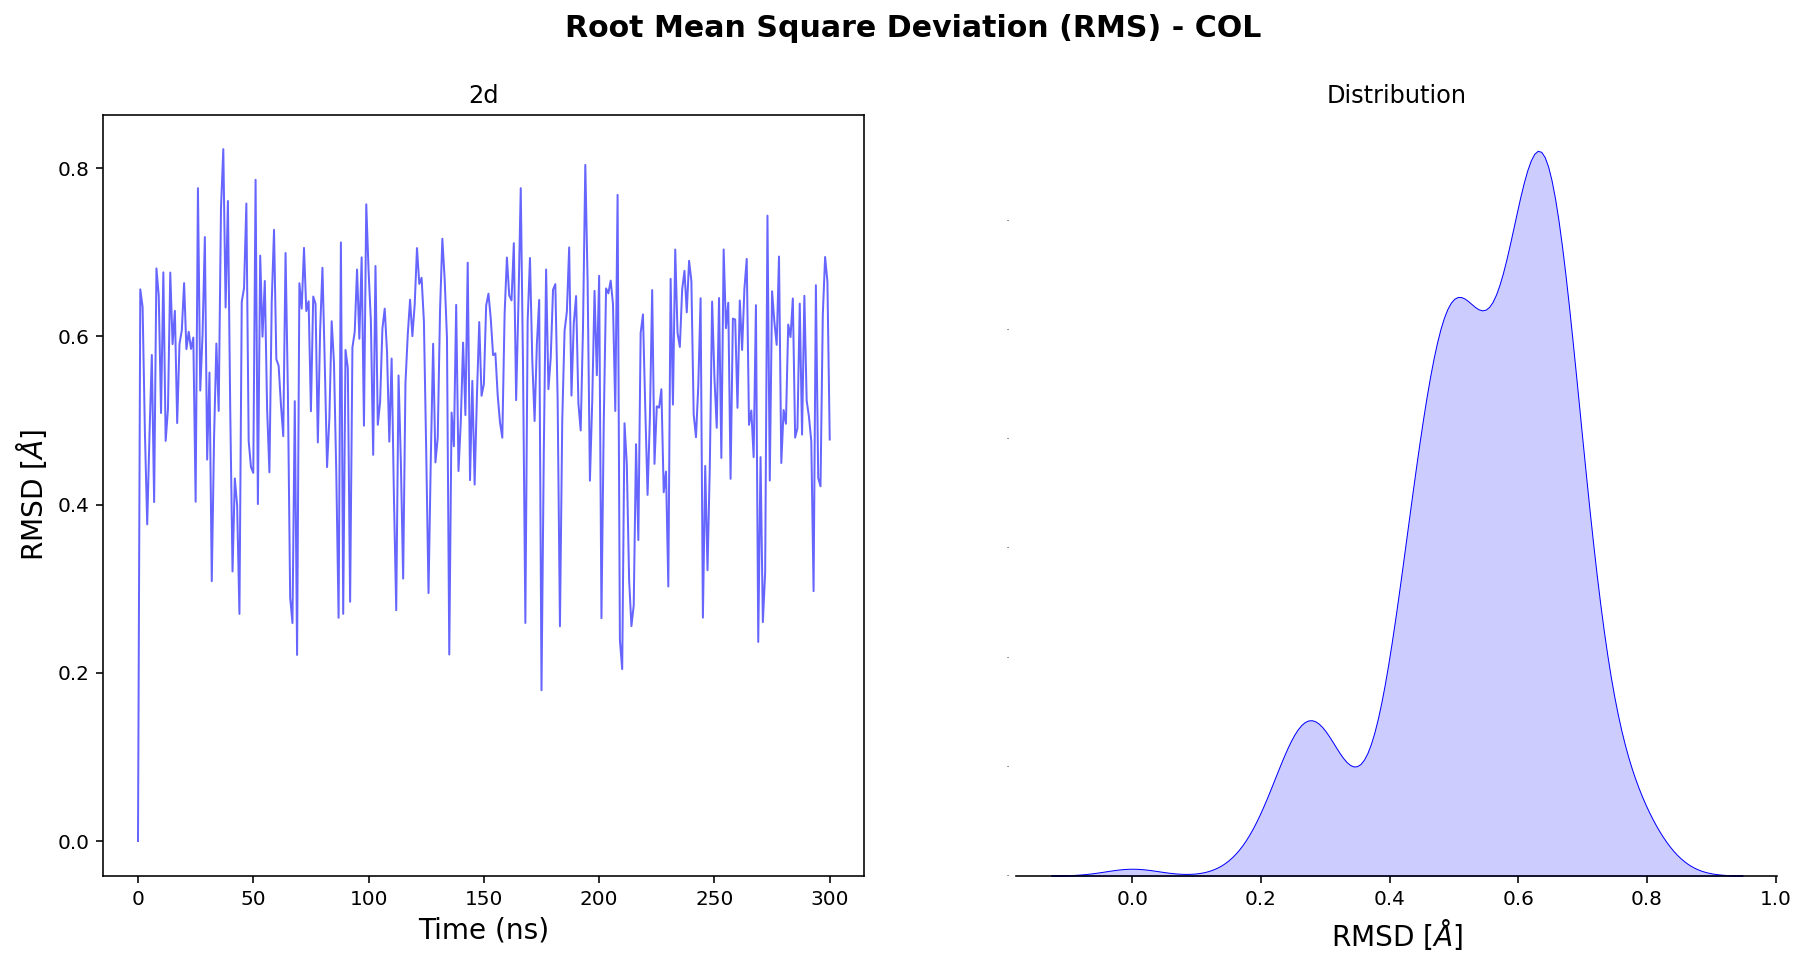

In [135]:
#@title **Compute RMSD**
plt.close()
Output_name = 'rmsd'+mask_label


rmsd = pt.rmsd(traj, ref=0, mask=mask)
data_rmsd_ref = pt.rmsd(traj, ref=0, mask=mask)

#Write_the_trajectory = 250000
#time = len(rmsd)*int(Write_the_trajectory)/1000
#time_array = np.arange(0,time,int(Write_the_trajectory)/1000)*int(stride_traj)

# Plotting:
fig, axs = plt.subplots(1, 2, figsize=(15,7))

axs[0].plot(rmsd, alpha=0.6, color = 'blue', linewidth = 1.0) #time_array,
#plt.xlim(0, simulation_ns)
#plt.ylim(2, 6)

axs[0].set_xlabel("Time (ns)", fontsize = 14)#, fontweight = 'bold')
axs[0].set_ylabel("RMSD [$\AA$]", fontsize = 14)#, fontweight = 'bold')
#axs[0].set_xticks(fontsize = 12); axs[0].set_yticks(fontsize = 12);
#axs[0].tick_params(axis=u'both', which=u'both', length=6, width=2)
axs[0].set_title('2d')

sb.kdeplot(rmsd, color="blue", shade=True, alpha=0.2, linewidth=0.5, ax=axs[1])
axs[1].set_xlabel('RMSD [$\AA$]', fontsize = 14)#, fontweight = 'bold')
axs[1].set_ylabel('')
axs[1].set_title('Distribution')
#axs[1].set_xticks(fontsize = 12) #axs[1].set_yticks(fontsize = 12)
axs[1].tick_params(axis='y', which='both', length=0, width=0, labelsize=0)
#axs[1].tick_params(axis='x', which='both', labelsize=10)

axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_visible(True)
axs[1].spines['left'].set_visible(False)

plt.suptitle("Root Mean Square Deviation (RMS) - "+mask_label[1:], fontsize=15, fontweight = 'bold');

#fig.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

#raw_data=pd.DataFrame(rmsd)
#raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

In [136]:
#@title **Compute radius of gyration**
plt.close()
Output_name = 'radius_gyration'+mask_label

radgyr = pt.radgyr(traj, mask=mask)#, mask = "@CA")

fig, axs = plt.subplots(1, 2, figsize=(15,7))

axs[0].set_title('2d')
axs[0].plot(radgyr, alpha=0.6, color = 'green', linewidth = 1.0) # time_array,
#axs[0].set_xlim(0, simulation_ns); axs[0].set_ylim(2, 6)
axs[0].set_xlabel("Time (ns)", fontsize = 14)#, fontweight = 'bold')
axs[0].set_ylabel("Radius of gyration ($\AA$)", fontsize = 14)#, fontweight = 'bold')
axs[0].tick_params(axis=u'both', which=u'both', length=6, width=2)
#axs[0].set_xticks(fontsize = 12)
#axs[0].set_yticks(fontsize = 12)


axs[1].set_title('Distribution')
sb.kdeplot(radgyr, color="green", shade=True, alpha=0.2, linewidth=0.5, ax=axs[1])
axs[1].set_xlabel('Radius of Gyration ($\AA$)', fontsize = 14)#, fontweight = 'bold')
#axs[1].set_xticks(fontsize = 12)
axs[1].tick_params(axis='y', which='both', length=0, width=0, labelsize=0)

axs[1].set_ylabel('')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_visible(True)
axs[1].spines['left'].set_visible(False)

plt.suptitle("Radius of Gyration - "+mask_label[1:], fontsize=15, fontweight = 'bold');
#fig.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

#raw_data=pd.DataFrame(radgyr)
#raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))


In [137]:
#@title **Compute RMSF**
plt.close()
Output_name = 'rmsf'+mask_label

rmsf = pt.rmsf(traj, mask=mask)#, "mask=@CA")
bfactor = pt.bfactors(traj, byres=True)

plt.figure(figsize=(11,7))
plt.title('Root Mean Square Fluctuation (RMSF) - '+mask_label[1:], fontweight = 'bold', fontsize = 18)
plt.plot(rmsf[:,1], alpha=1.0, marker="o", color='red', linewidth = 1.0)

plt.xlabel("Residue", fontsize = 14)#, fontweight = 'bold')
plt.ylabel("RMSF ($\AA$)", fontsize = 14)#, fontweight = 'bold')
plt.xticks(fontsize = 12);
plt.xlim(0, len(rmsf[:-1]))

#plt.xticks(np.arange(min(rmsf[:1]), max(rmsf[:1])))
plt.yticks(fontsize = 12);

#plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

#raw_data=pd.DataFrame(rmsf)
#raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

CPU times: user 317 ms, sys: 104 ms, total: 420 ms
Wall time: 1.01 s


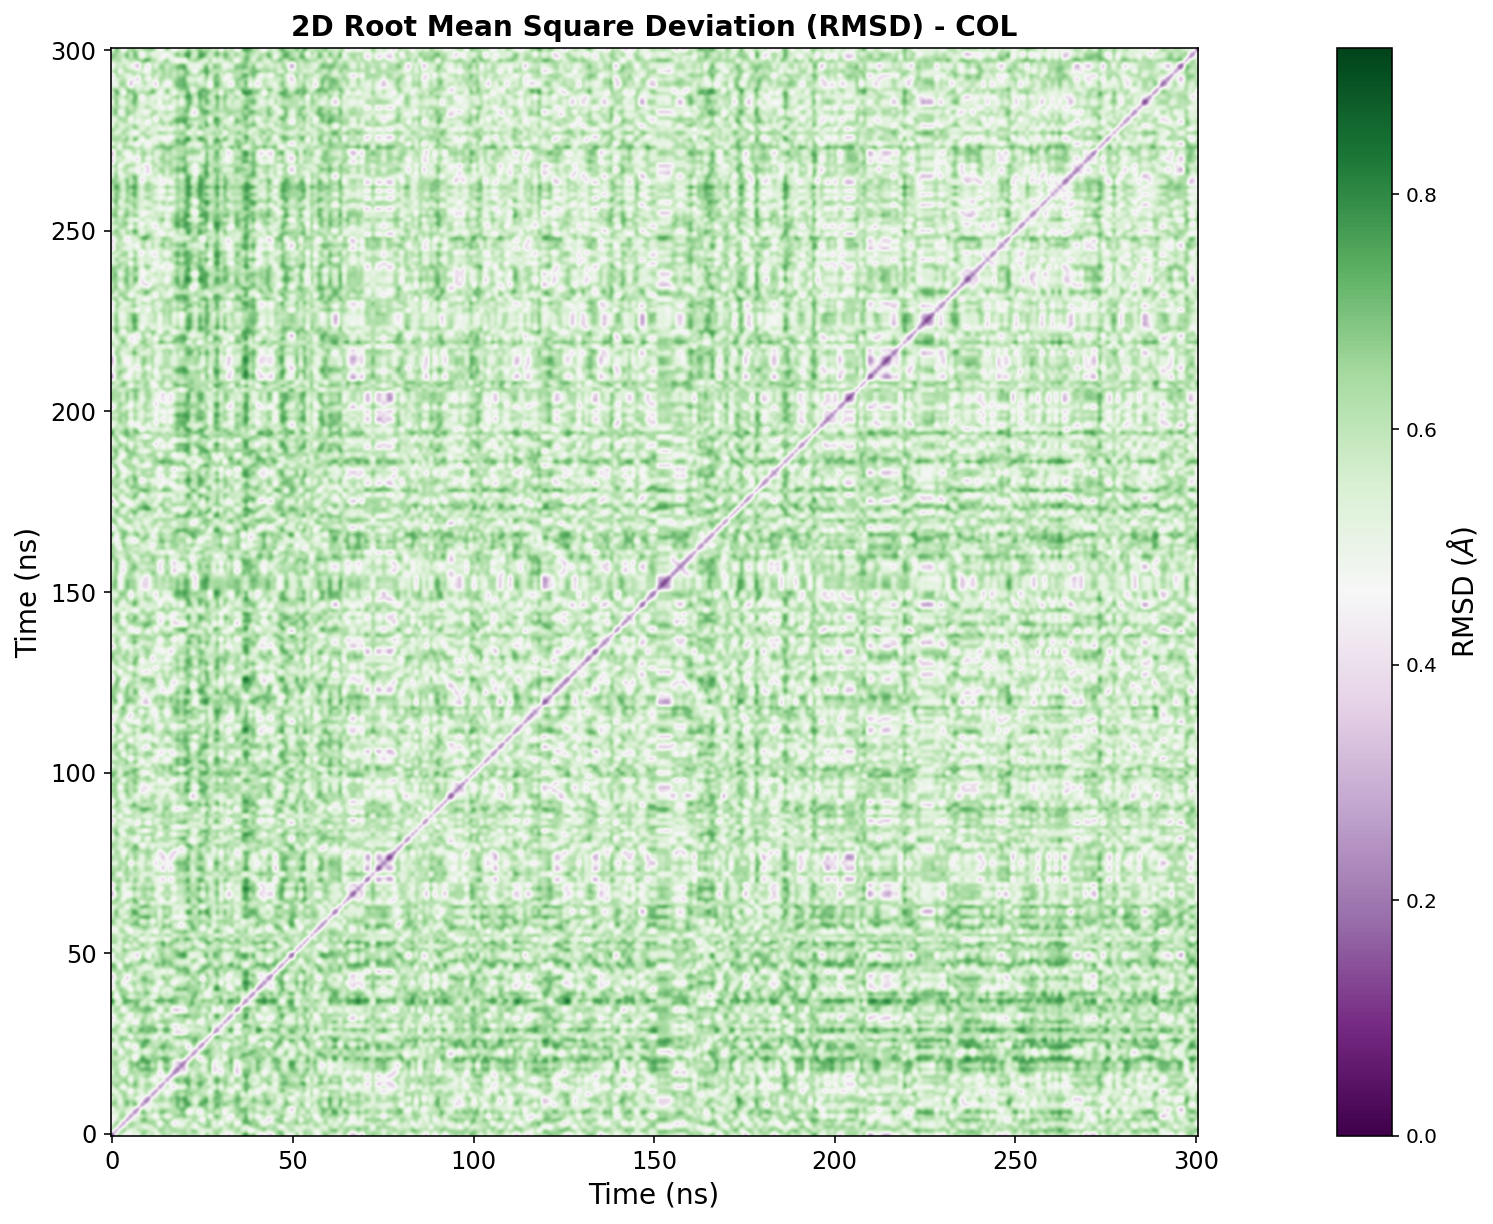

In [138]:
%%time
#@title **2D RMSD**
plt.close()
Output_name = '2D_rmsd'+mask_label

#last_frame = len(time_array)
#stride_ticks_f = (last_frame)/5
#ticks_frame = np.arange(0,(len(time_array) + float(stride_ticks_f)), float(stride_ticks_f)).astype(float)
#a = ticks_frame.astype(float)
#stride_ticks_t = (simulation_ns)/5
#tick_time = np.arange(0,(float(simulation_ns) + float(stride_ticks_t)), float(stride_ticks_t)).astype(float)
#b = tick_time.astype(float)

mat1 = pt.pairwise_rmsd(traj, mask=mask)#, frame_indices=range(int(number_frames_analysis)))

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # high resolution

plt.figure(figsize = (25,10))
plt.title('2D Root Mean Square Deviation (RMSD) - '+mask_label[1:], fontsize = 14, fontweight = 'bold')

plt.imshow(mat1, cmap = 'PRGn', origin='lower', interpolation = 'bicubic')
plt.xlabel('Time (ns)', fontsize = 14)#, fontweight = 'bold')
plt.ylabel('Time (ns)', fontsize = 14)#, fontweight = 'bold')
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
#plt.xticks(ticks_frame, tick_time.round(decimals=3), fontsize = 12)
#plt.yticks(ticks_frame, tick_time.round(decimals=3), fontsize = 12)
# plt.xlim(0, a[-1]);  plt.ylim(0, a[-1])

cbar1 = plt.colorbar()
cbar1.set_label("RMSD ($\AA$)", fontsize = 14)#, fontweight = 'bold')


#plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

#raw_data=pd.DataFrame(mat1)
#raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

In [139]:
%%time
#@title **Calculate eigvenctors of Principle Component Analysis (PCA)**
plt.close()
data = pt.pca(traj, fit=True, ref=0, mask=mask, n_vecs=2)

#print('projection values of each frame to first mode = {} \n'.format(data[0][0]))
#print('projection values of each frame to second mode = {} \n'.format(data[0][1]))
#print('eigvenvalues of first two modes', data[1][0])
#print("")
#print('eigvenvectors of first two modes: \n', data[1][1])

#last_frame = len(time_array)

#stride_ticks_f = (last_frame)/5
#ticks_frame = np.arange(0,(len(time_array) + float(stride_ticks_f)), float(stride_ticks_f))
#a = ticks_frame.astype(float)
#a2 = a.tolist()
#stride_ticks_t = (simulation_ns)/5
#tick_time = np.arange(0,(float(simulation_ns) + float(stride_ticks_t)), float(stride_ticks_t))
#b = tick_time.astype(float)

#@markdown **Provide output file names below:** 
Output_name = 'PCA_'+mask[1:] 

Output_PC1 = 'PC1' #@param {type:"string"}
Output_PC2 = 'PC2' #@param {type:"string"}

%matplotlib ipympl
#%config InlineBackend.figure_format = 'retina'  # high resolution

plt.figure(figsize = (15,9))
plt.title(r'Principle Component Analysis (PCA) of '+mask_label[1:], fontsize=18, fontweight='bold')

projection_data = data[0]
PC1, PC2 = data[0][0], data[0][1]

plt.scatter(PC1,PC2, c=range(int(number_frames_analysis)), cmap='Greens', marker='o', s=20, alpha=1) #
#plt.clim(0, last_frame)

plt.xlabel('PC1', fontsize = 14)#, fontweight = 'bold')
plt.ylabel('PC2', fontsize = 14)#, fontweight = 'bold')
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
# N = len(number_frames)
# x2 = np.arange(N)

cbar1 = plt.colorbar(a, orientation="vertical")
cbar1.set_label('Time(ns)', fontsize = 14)#, fontweight = 'bold')
#cbar1.set_ticks(ticks_frame.tolist())
#cbar1.set_ticklabels(tick_time.round(decimals=3))

#plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

#pc1=pd.DataFrame(PC1)
#pc1.to_csv(os.path.join(workDir, Output_PC1 + ".csv"))
#pc2=pd.DataFrame(PC2)
#pc2.to_csv(os.path.join(workDir, Output_PC2 + ".csv"))

<timed exec>:45: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


CPU times: user 805 ms, sys: 232 ms, total: 1.04 s
Wall time: 2.23 s


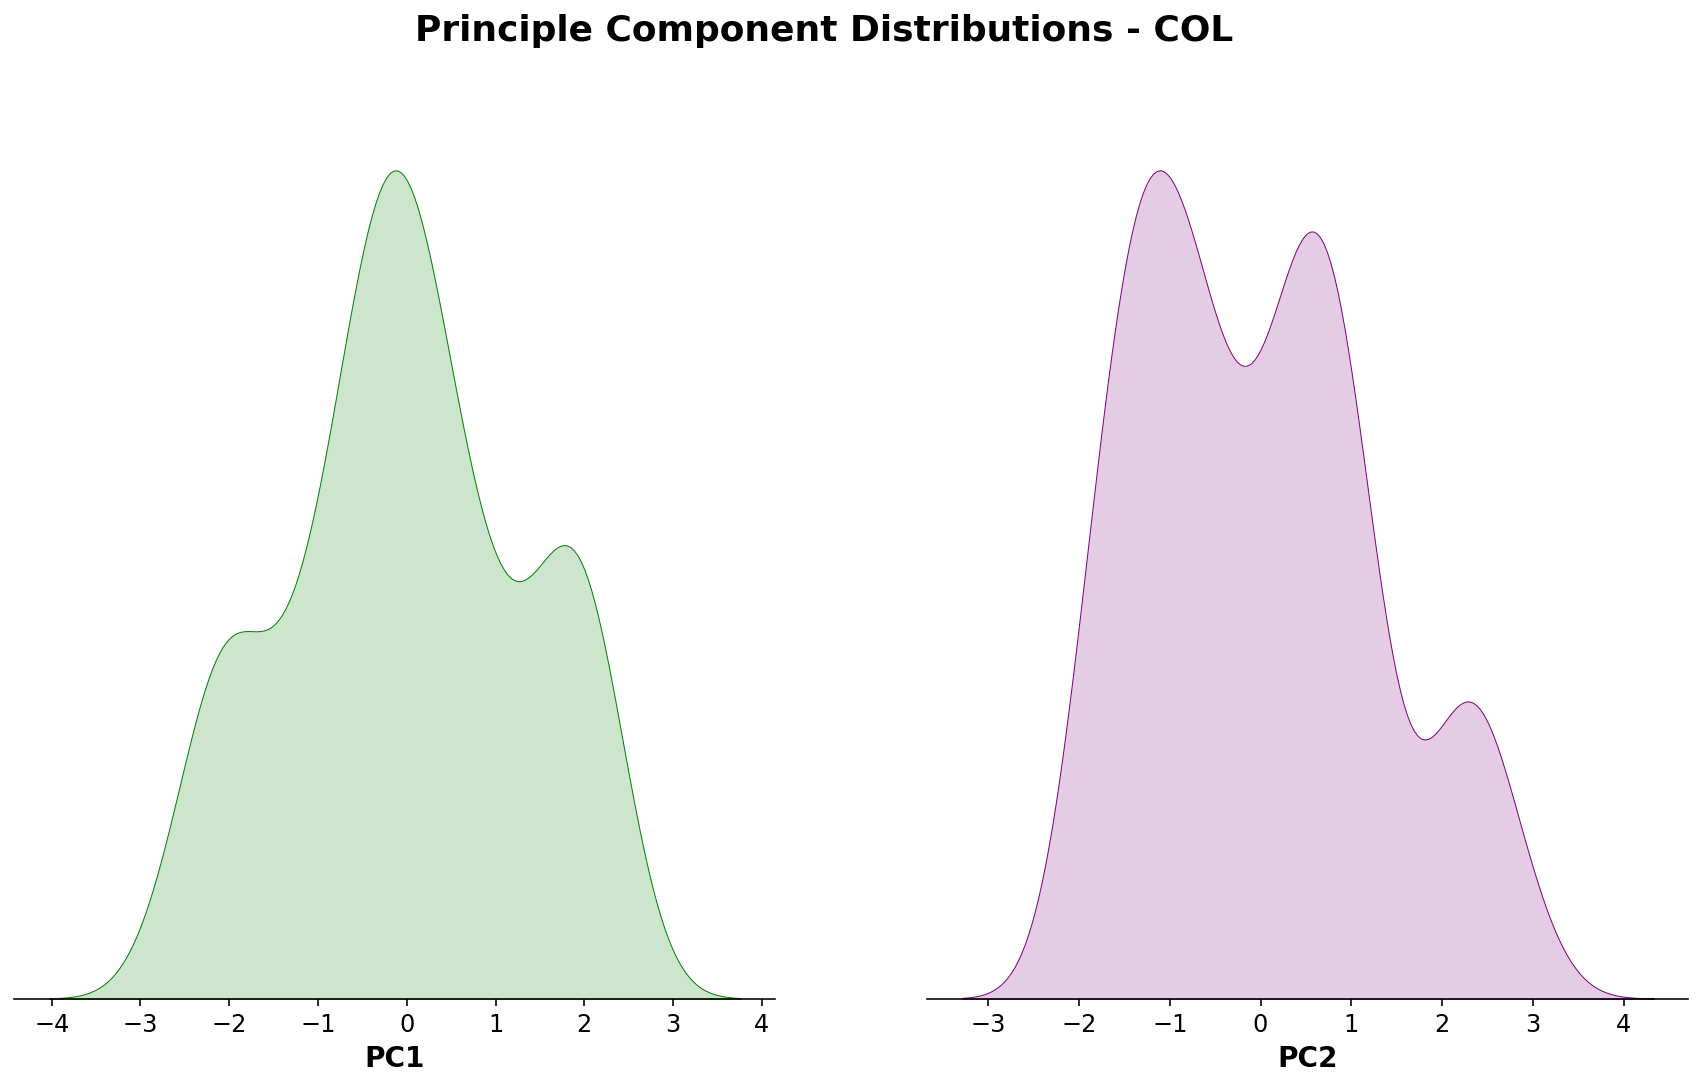

In [141]:
#@title **Plot Principal Component 1 (PC1) and Principal Component 2 (PC2) as a ditribution**
plt.close()
Output_name = 'PCA_dist'+mask_label

fig = plt.figure(figsize=(15,8))

plt.subplot(1, 2, 1)
ax = sb.kdeplot(PC1, color="green", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('PC1', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
plt.subplot(1, 2, 2)
ax2 = sb.kdeplot(PC2, color="purple", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('PC2', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(False)

plt.suptitle('Principle Component Distributions - '+mask_label[1:], fontsize=18, fontweight='bold');

#plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

CPU times: user 370 ms, sys: 95 ms, total: 465 ms
Wall time: 435 ms


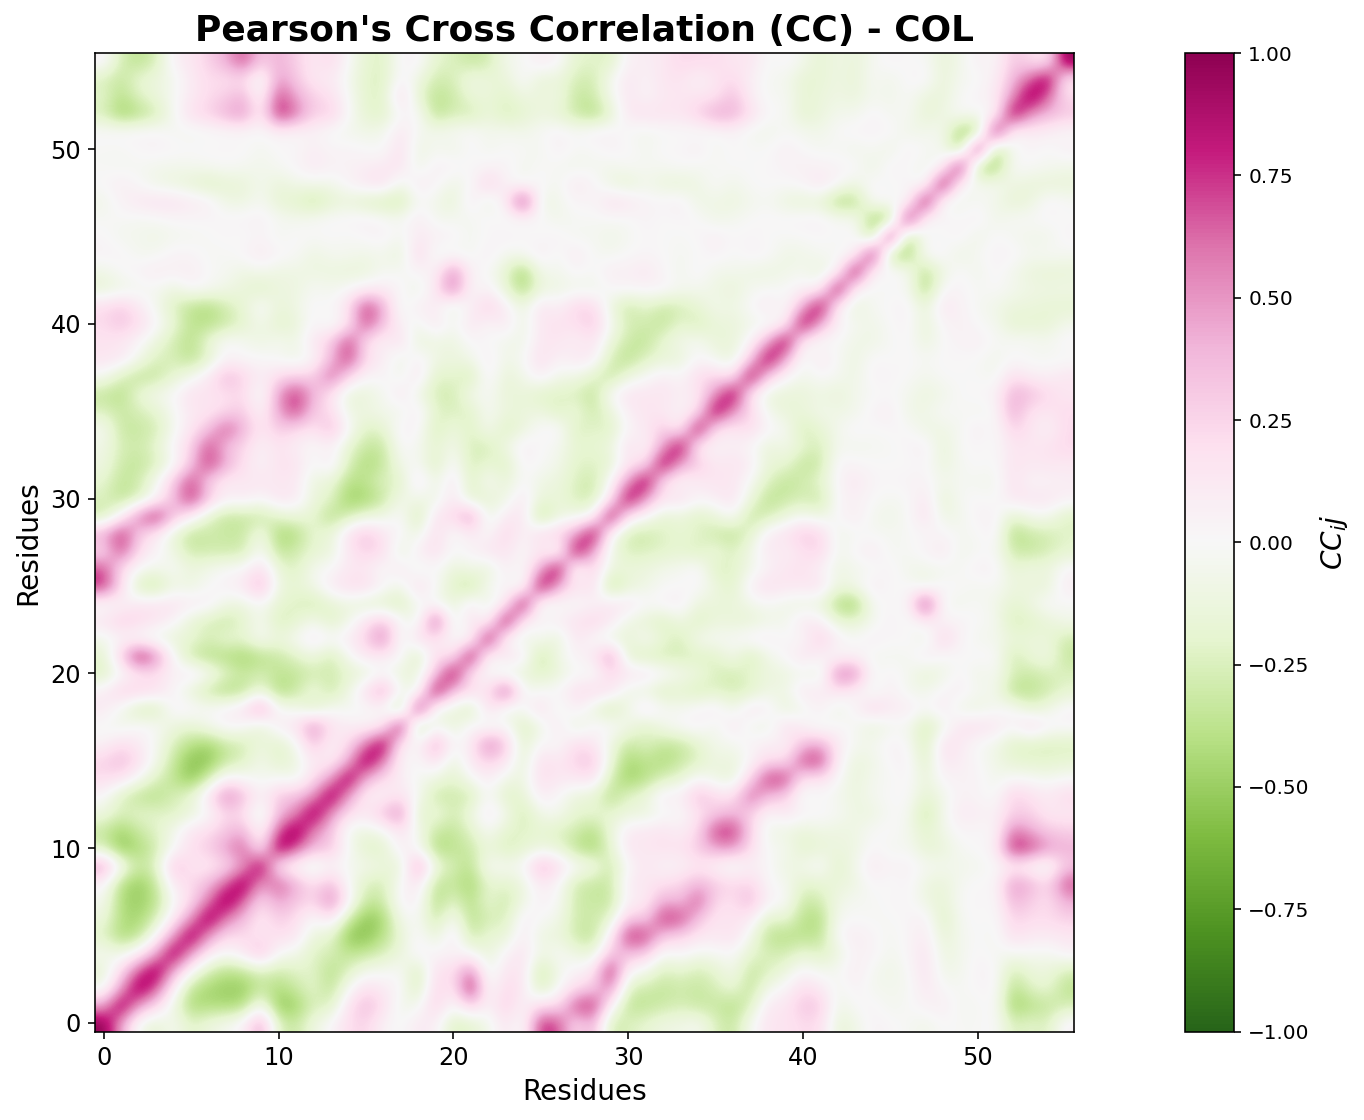

In [142]:
%%time
#@title **Pearson's Cross Correlation (CC)**
plt.close()
Output_name = 'cross_correlation'+mask_label

traj_align = pt.align(traj, ref=0, mask=mask) # , mask='@CA'
mat_cc = matrix.correl(traj_align, mask=mask)#, mask='@CA')

plt.figure(figsize=(20,9))
plt.title("Pearson's Cross Correlation (CC) - "+mask_label[1:], fontsize=18, fontweight = 'bold')
ax = plt.imshow(mat_cc, cmap = 'PiYG_r', interpolation = 'bicubic', vmin = -1, vmax = 1, origin='lower')

plt.xlabel('Residues', fontsize=14)#, fontweight = 'bold')
plt.ylabel('Residues', fontsize=14)#, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
cbar1 = plt.colorbar()
cbar1.set_label('$CC_ij$', fontsize = 14)#, fontweight = 'bold')

#plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

#raw_data=pd.DataFrame(mat_cc)
#raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

**Interaction Energy**

To quantify the strength of the interaction between the ligand and the protein, we will compute the nonbonded interaction energy between these two species.  It is important to note that this quantity is NOT a free energy or a binding energy. 


Interaction Energy Average = -68.39 ± 3.00 kcal/mol
CPU times: user 3min 59s, sys: 1.42 s, total: 4min 1s
Wall time: 4min 2s


[None, None]

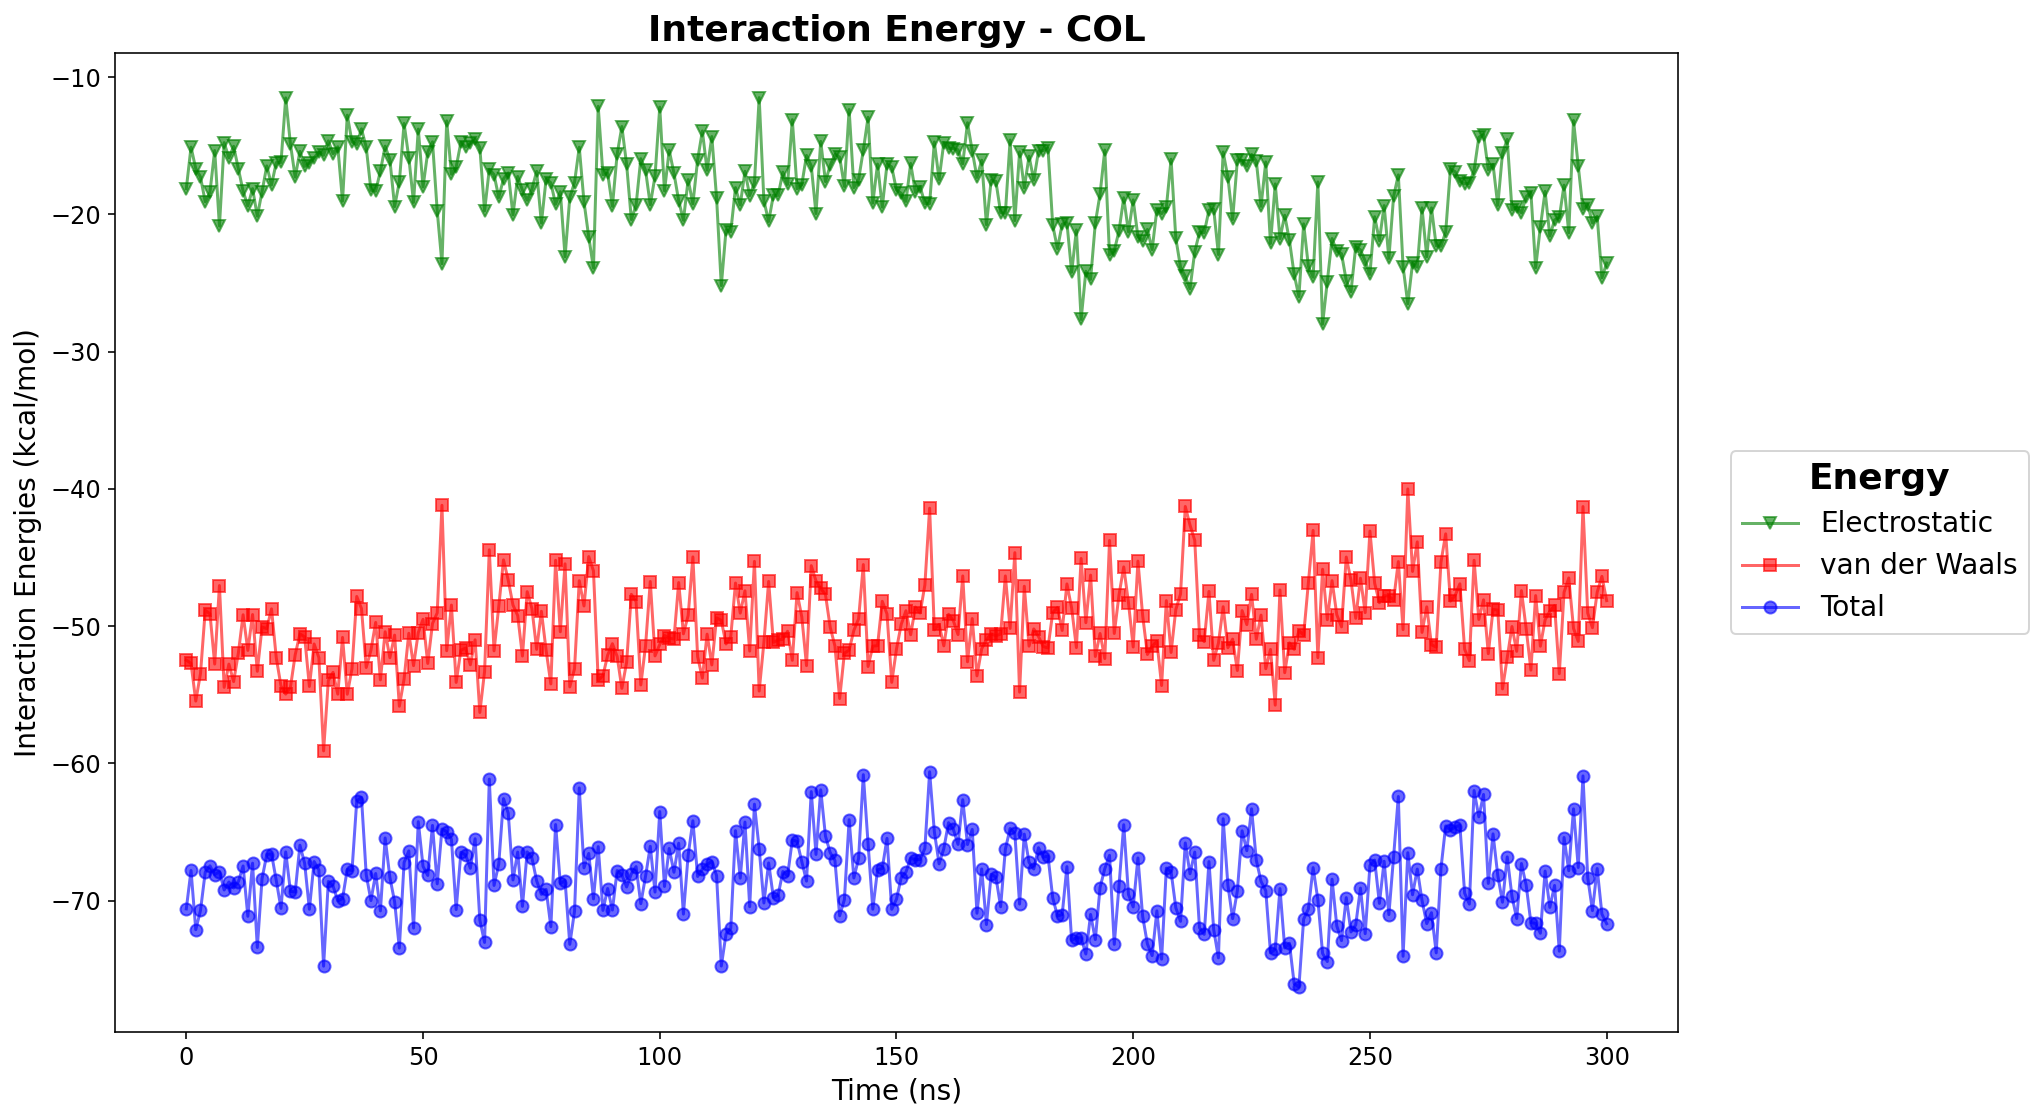

In [145]:
%%time
plt.close()
Output_name = 'Interaction_energy'+mask_label

pt_topology = traj.top
restraint_array = pt.select_atoms('!(:WAT) & !(:Na+) & !(:Cl-) & !(:Mg+) & !(:K+) & !(:LIG)', pt_topology)
first_atom = restraint_array[0]
last_atom = restraint_array[-1]

lie = pt.analysis.energy_analysis.lie(traj, mask=mask, options='cutvdw 12.0 cutelec 12.0 diel 2.0', dtype='dict')

lie_elec = lie['LIE[EELEC]']
lie_vdw = lie['LIE[EVDW]']
lie_total = lie_elec + lie_vdw
lie_total_mean = mean(lie_total)
lie_total_stdev = stdev(lie_total)
print("Interaction Energy Average = " + str("{:.2f}".format(lie_total_mean)) + " \u00B1 " + str("{:.2f}".format(lie_total_stdev)) + " kcal/mol")

plt.figure(figsize=(14,9))
plt.title('Interaction Energy - '+mask_label[1:], fontsize=18, fontweight='bold')
plt.plot( lie_elec, alpha=0.6, marker="v", color = 'green', linewidth = 1.5, label= "Electrostatic")
plt.plot(lie_vdw, alpha=0.6, marker="s", color = 'red', linewidth = 1.5, label= "van der Waals")
plt.plot( lie_total, alpha=0.6, marker="o", color = 'blue', linewidth = 1.5, label= "Total")

#plt.xlim(0, simulation_ns)
#plt.ylim(2, 6)

plt.xlabel("Time (ns)", fontsize = 14)#, fontweight = 'bold')
plt.ylabel('Interaction Energies (kcal/mol)', fontsize = 14)#, fontweight = 'bold')
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12);
legend = plt.legend(frameon=True, loc='center left', bbox_to_anchor=(1.025, 0.5), fontsize=14, title='Energy')

plt.setp(legend.get_title(),fontsize='18', fontweight="bold")


#plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

#lie_eelec = pd.DataFrame(lie['LIE[EELEC]'])
#lie_eelec.to_csv(os.path.join(workDir, Output_name + "_eelec.csv"))
#lie_evdw = pd.DataFrame(lie['LIE[EVDW]'])
#lie_evdw.to_csv(os.path.join(workDir, Output_name + "_evdw.csv"))

In [192]:
h = sb.jointplot(rmsd, radgyr, color="#31a354", kind="reg")

h.set_axis_labels('x', 'y', fontsize=16)

# or set labels via the axes objects
h.ax_joint.set_xlabel("RMSD [$\AA$]", fontsize=12)
h.ax_joint.set_ylabel('Radius of Gyration ($\AA$)', fontsize=12)
h.ax_joint.set_title('as')
# also possible to manipulate the histogram plots this way, e.g.
h.ax_marg_y.grid('on') # with ugly consequences...

# labels appear outside of plot area, so auto-adjust
h.figure.tight_layout() 


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


# Trajectory visualization

[nglview](https://github.com/nglviewer/nglview) and [pytraj](https://github.com/Amber-MD/pytraj)

In [156]:
import nglview as nv
from google.colab import output

traj_iter = pt.iterload(nc_name, param_name)
traj_iter

pytraj.TrajectoryIterator, 301 frames: 
Size: 0.331059 (GB)
<Topology: 49207 atoms, 15294 residues, 15038 mols, PBC with box type = orthorhombic>
           

pytraj.TrajectoryIterator, 301 frames: 
Size: 0.331059 (GB)
<Topology: 49207 atoms, 15294 residues, 15038 mols, PBC with box type = orthorhombic>
           

In [158]:
output.enable_custom_widget_manager()

#view = nv.show_pytraj(traj)
#view

output.disable_custom_widget_manager()

# **LiBELa**

In [193]:
#! apt-get install libboost-python1.71-dev openbabel python-dev
#!mamba install -c anaconda libboost
#!pip -q install libboost
!python --version

Python 3.8.15


In [92]:
#! rm -f pyPARSER*
!wget https://raw.githubusercontent.com/alessandronascimento/pyLiBELa/main/src/pyPARSER.cpp
!wget https://raw.githubusercontent.com/alessandronascimento/pyLiBELa/main/src/pyPARSER.h
!g++ -Wall -Wextra -fPIC -shared -I/usr/include/python3.8 pyPARSER.cpp -o pyPARSER.so -L/usr/lib/x86_64-linux-gnu -lboost_python38
# warnings extra_warning optimizaiton public  library of files of cpp       linking code

--2023-03-03 17:21:01--  https://raw.githubusercontent.com/alessandronascimento/pyLiBELa/main/src/pyPARSER.cpp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22346 (22K) [text/plain]
Saving to: ‘pyPARSER.cpp’

pyPARSER.cpp        100%[===================>]  21.82K  --.-KB/s    in 0s      

2023-03-03 17:21:01 (69.1 MB/s) - ‘pyPARSER.cpp’ saved [22346/22346]

--2023-03-03 17:21:01--  https://raw.githubusercontent.com/alessandronascimento/pyLiBELa/main/src/pyPARSER.h
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12042 (12K) [text

In [ ]:
!ls

condacolab_install.log	openff_unconstrained-2.0.0.offxml  prolif.sh
drive			ProLIF				   sample_data
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pyPARSER: filename=pyparser-1.0-py3-none-any.whl size=4921 sha256=4d025e9b622bb7c5d724d4b5fe04b365feb60c4c15e8e242b6fddeb909d197ba
  Stored in directory: /root/.cache/pip/wheels/d5/c1/97/c8d64328b6d76c0393314e67e06e366a75b7ffdf0406d2afc3
  Created wheel for parse: filename=parse-1.6.5-py3-none-any.whl size=18155 sha256=fa1e76cde17d567b61e237a229ca77289feacc114c9819c2b6433027c36b29a0
  Stored in directory: /root/.cache/pip/wheels/ec/be/db/6c913790b51ae090743152e15158ee7effdaefea9a940330e6
Successfully built pyPARSER parse


In [89]:
from pyparsing import *



AttributeError: ignored

In [ ]:
#from pyPARSER import *
from pyparsing import *

Input = PARSER()

print(Input.temp)

NameError: ignored

In [ ]:
pyparsing.PARSER

NameError: ignored